In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv('data2.csv')

# Make sure your text data does not contain NaN values
df['lemmatized-comment'].replace('', np.nan, inplace=True)
df.dropna(subset=['lemmatized-comment'], inplace=True)

# Split the data into training and validation datasets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['lemmatized-comment'], df['numerical-label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.1, 
                                                                    stratify=df['numerical-label'])

# We'll further split the validation set into validation and test datasets
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.3, 
                                                                stratify=temp_labels)



In [39]:
from transformers import BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

# Load pre-trained model tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Encode the text
test_encodings = tokenizer(test_text.tolist(), truncation=True, padding=True, max_length=256)

# Convert inputs to PyTorch tensors
test_inputs = torch.tensor(test_encodings['input_ids'])
test_labels = torch.tensor(test_labels.tolist())
test_masks = torch.tensor(test_encodings['attention_mask'])

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=16)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


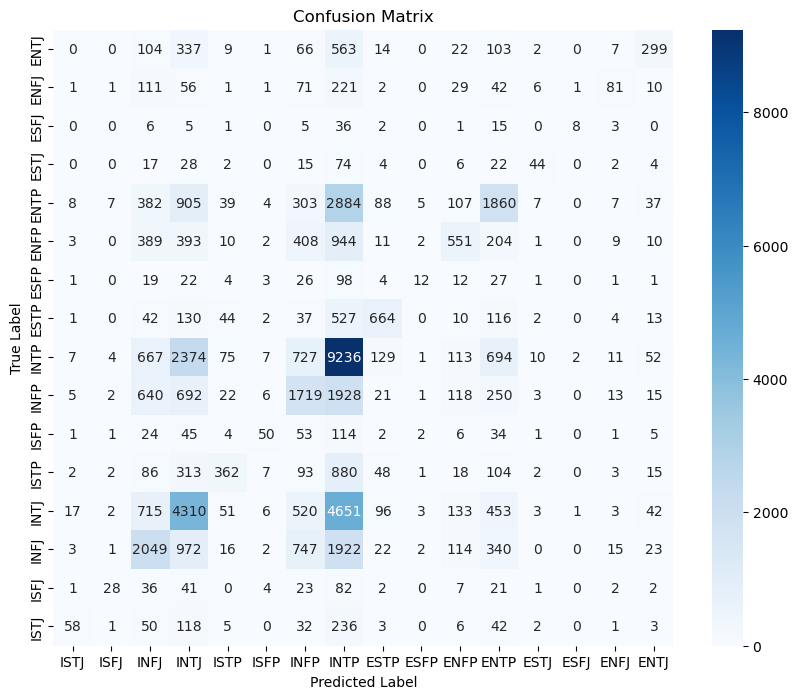

Predictions and accuracy saved to 'big_data_1.txt'


In [44]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# Load the saved BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=16)
model.load_state_dict(torch.load('final_model.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Assuming you have test_dataloader defined and ready to use

def evaluate_test_set(test_dataloader, top_n):
    predictions = []
    true_labels = []
    correct_predictions = 0

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Tell the model not to compute or store gradients
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Get the top N predictions with probabilities for each sample in the batch
        top_n_indices = np.argsort(logits, axis=1)[:, -top_n:][:, ::-1]
        top_n_probs = np.take_along_axis(logits, top_n_indices, axis=1)

        # Convert the predicted indices and probabilities to their corresponding labels
        batch_predictions = []
        for sample_probs, sample_indices in zip(top_n_probs, top_n_indices):
            sample_predictions = [
                (label_id, prob) for label_id, prob in zip(sample_indices, sample_probs)
            ]
            batch_predictions.append(sample_predictions)

        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

        # Check if the true label is in the top N predictions
        for sample_preds, true_label_id in zip(batch_predictions, label_ids):
            if true_label_id in [pred_label_id for pred_label_id, _ in sample_preds]:
                correct_predictions += 1

    total_samples = len(test_dataloader.dataset)
    accuracy = correct_predictions / total_samples

    return predictions, true_labels, accuracy

# Call the function to get the top 3 predictions with probabilities and calculate accuracy
predictions, true_labels, accuracy = evaluate_test_set(test_dataloader, top_n=1)


import seaborn as sns
import matplotlib.pyplot as plt




# Assuming you have a label mapping for the 16 MBTI types
label_mapping = {
    0: "ISTJ",
    1: "ISFJ",
    2: "INFJ",
    3: "INTJ",
    4: "ISTP",
    5: "ISFP",
    6: "INFP",
    7: "INTP",
    8: "ESTP",
    9: "ESFP",
    10: "ENFP",
    11: "ENTP",
    12: "ESTJ",
    13: "ESFJ",
    14: "ENFJ",
    15: "ENTJ",

}

# Create an empty confusion matrix
confusion_matrix = np.zeros((16, 16), dtype=int)

# Fill the confusion matrix based on predictions and true labels
for sample_preds, true_label_id in zip(predictions, true_labels):
    pred_label_id = sample_preds[0][0]  # Take the top prediction
    confusion_matrix[true_label_id, pred_label_id] += 1

# Convert the confusion matrix to a DataFrame for seaborn heatmap
confusion_df = pd.DataFrame(confusion_matrix, index=label_mapping.values(), columns=label_mapping.values())

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df[::-1], annot=True, fmt='d', cmap='Blues')  # Use [::-1] to mirror the rows
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# Define the output file path
output_file = 'big_data_1.txt'

# Create or open the output file for writing
with open(output_file, 'w') as f:
    # Write the top 3 predictions, true labels, and accuracy to the file
    for sample_preds, true_label_id in zip(predictions, true_labels):
        true_label = label_mapping[true_label_id]
        f.write(f"True Label: {true_label}\n")

        for rank, (pred_label_id, prob) in enumerate(sample_preds, 1):
            pred_label = label_mapping[pred_label_id]
            f.write(f"{rank}. {pred_label}: {prob:.2f}%\n")

        f.write('\n')  # Add a newline between samples

    f.write(f"Accuracy: {accuracy * 100:.2f}%\n")

print(f"Predictions and accuracy saved to '{output_file}'")

